**STEP 1: SETUP**

In [3]:
import pandas as pd
from google.colab import drive

# Define the path to the CSV file
# If you used Option A (Drive), uncomment the line below:
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/readmission_shield/data/diabetic_data.csv'

# If you used Option B (Quick Start), use this:
# file_path = 'readmission_shield/data/diabetic_data.csv'

# Load the data
# We specify 'na_values' because this specific dataset uses '?' for missing data
df = pd.read_csv(file_path, na_values=['?'])

# 1. Check shape
print(f"Dataset Shape: {df.shape}")

# 2. Check the Target Variable
print("\nTarget Variable Distribution:")
print(df['readmitted'].value_counts())

# 3. Peek at the data
pd.set_option('display.max_columns', None)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-271900270.py:14: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, na_values=['?'])


Dataset Shape: (101766, 50)

Target Variable Distribution:
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


**STEP 2: CLEANING & PREPROCESSING (REVISED)**

In [5]:
# 1. Drop the columns with >95% missing data (Noise)
# based on your snapshot showing they are empty
df_clean = df.drop(['weight', 'payer_code'], axis=1)

# 2. Filter out Death/Hospice (Cannot be readmitted)
# Discharge IDs: 11, 13, 14, 19, 20, 21 = Expired or Hospice
df_clean = df_clean[~df_clean['discharge_disposition_id'].isin([11, 13, 14, 19, 20, 21])]

# 3. Fix the "Meaningful Missing" values
# For these, NaN means "Not Measured" or "Unknown", which is valuable info.
fill_values = {
    'medical_specialty': 'Missing',
    'race': 'Missing',
    'max_glu_serum': 'None',
    'A1Cresult': 'None'
}
df_clean = df_clean.fillna(value=fill_values)

# 4. Correct Data Types (The "V-Code" & ID Fix)
# Convert IDs to strings so model treats them as categories, not numbers
id_cols = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
df_clean[id_cols] = df_clean[id_cols].astype(str)

# Force diagnosis codes to be strings (handling the mixed '250.83' and 'V27')
diag_cols = ['diag_1', 'diag_2', 'diag_3']
df_clean[diag_cols] = df_clean[diag_cols].astype(str)

# 5. Handle Patient Overlap (Prevent Data Leakage)
# Sort by Patient ID first, then keep only the FIRST encounter.
# This ensures we don't train and test on the same patient.
df_clean = df_clean.sort_values(['patient_nbr', 'encounter_id'])
df_clean = df_clean.drop_duplicates(subset='patient_nbr', keep='first')

# 6. Create Binary Target
# 1 if Readmitted <30 days, 0 otherwise
df_clean['target'] = (df_clean['readmitted'] == '<30').astype(int)

# 7. Final Sanity Check
print(f"Final Dataset Shape: {df_clean.shape}")
print("-" * 30)
print("Target Distribution (Readmitted <30 days):")
print(df_clean['target'].value_counts(normalize=True))
print("-" * 30)
print("Data Types Check:")
print(df_clean[['admission_type_id', 'diag_1']].dtypes)

Final Dataset Shape: (69990, 49)
------------------------------
Target Distribution (Readmitted <30 days):
target
0    0.910201
1    0.089799
Name: proportion, dtype: float64
------------------------------
Data Types Check:
admission_type_id    object
diag_1               object
dtype: object


**STEP 3: FEATURE ENGINEERING (The "Secret Sauce")**

In [6]:
# 1. Age Conversion (Ordinal Encoding)
# The age is currently '[0-10)', '[10-20)', etc.
# We map these to simple numbers: 0, 1, 2... so the model understands 'older > younger'
age_dict = {
    '[0-10)': 0, '[10-20)': 1, '[20-30)': 2, '[30-40)': 3,
    '[40-50)': 4, '[50-60)': 5, '[60-70)': 6, '[70-80)': 7,
    '[80-90)': 8, '[90-100)': 9
}
df_clean['age_group'] = df_clean['age'].replace(age_dict)

# 2. Service Utilization (Interaction Feature)
# A patient who visits the ER, Inpatient, AND Outpatient is a "Frequent Flyer"
# This single number summarizes their recent hospital usage history.
df_clean['service_utilization'] = (
    df_clean['number_outpatient'] +
    df_clean['number_emergency'] +
    df_clean['number_inpatient']
)

# 3. ICD-9 Code Grouping (The Hard Part)
# We need to group 700+ codes into 9 distinct categories.
def map_diagnosis(code):
    if str(code).startswith(('V', 'E')):
        return 'Other' # V-codes (health factors) & E-codes (external causes)
    try:
        n = float(code)
    except ValueError:
        return 'Other' # If it's weird, put it in Other

    # Standard ICD-9 Ranges
    if 390 <= n <= 459 or n == 785: return 'Circulatory'
    if 460 <= n <= 519 or n == 786: return 'Respiratory'
    if 520 <= n <= 579 or n == 787: return 'Digestive'
    if 250 <= n < 251: return 'Diabetes'
    if 800 <= n <= 999: return 'Injury'
    if 710 <= n <= 739: return 'Musculoskeletal'
    if 580 <= n <= 629 or n == 788: return 'Genitourinary'
    if 140 <= n <= 239: return 'Neoplasms' # Cancer
    return 'Other' # Everything else

# Apply this map to the primary diagnosis (diag_1)
df_clean['primary_diagnosis'] = df_clean['diag_1'].apply(map_diagnosis)

# 4. Medication Change Indicator
# If the 'change' column is 'Ch', it means meds were altered. This is high risk.
df_clean['med_change'] = (df_clean['change'] == 'Ch').astype(int)

# 5. Diabetes Meds Prescribed
# If 'diabetesMed' is 'Yes', they are on meds.
df_clean['has_diabetes_med'] = (df_clean['diabetesMed'] == 'Yes').astype(int)

# 6. Final Feature Selection
# We drop the raw columns we just engineered (like diag_1, age, change) to avoid redundancy
cols_to_keep = [
    'target', 'race', 'gender', 'age_group',
    'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
    'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
    'service_utilization', 'primary_diagnosis',
    'max_glu_serum', 'A1Cresult', 'insulin', 'med_change', 'has_diabetes_med'
]

df_model = df_clean[cols_to_keep].copy()

# 7. Check the new "Engineered" Dataframe
print(f"Modeling Data Shape: {df_model.shape}")
print("-" * 30)
print("New Diagnosis Groups:")
print(df_model['primary_diagnosis'].value_counts())
print("-" * 30)
print("Preview of Final Data:")
df_model.head()

/tmp/ipython-input-1818284312.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['age_group'] = df_clean['age'].replace(age_dict)


Modeling Data Shape: (69990, 18)
------------------------------
New Diagnosis Groups:
primary_diagnosis
Circulatory        21390
Other              12134
Respiratory         9491
Digestive           6488
Diabetes            5748
Injury              4696
Musculoskeletal     4064
Genitourinary       3441
Neoplasms           2538
Name: count, dtype: int64
------------------------------
Preview of Final Data:


,target,race,gender,age_group,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,service_utilization,primary_diagnosis,max_glu_serum,A1Cresult,insulin,med_change,has_diabetes_med
4267,1,Caucasian,Female,5,2,1,1,8,77,6,33,0,Circulatory,None,None,Steady,1,1
5827,0,Caucasian,Female,5,3,1,1,2,49,1,11,0,Musculoskeletal,None,None,No,0,0
67608,0,Caucasian,Female,8,1,3,7,4,68,2,23,0,Injury,None,>7,No,0,1
17494,0,Caucasian,Female,8,1,1,7,3,46,0,20,0,Other,None,>8,No,1,1
2270,0,AfricanAmerican,Female,3,1,1,7,5,49,0,5,0,Genitourinary,None,None,No,0,1


**STEP 4: PRE-PROCESSING & MODEL TRAINING**

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import xgboost as xgb

# 1. One-Hot Encoding
# Convert categorical columns into 0/1 columns
X = pd.get_dummies(df_model.drop('target', axis=1), drop_first=True)
y = df_model['target']

print(f"Final Feature Count: {X.shape[1]}")

# 2. Train/Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Calculate Scale Weight
# Formula: (Number of Negative / Number of Positive)
ratio = float(np.sum(y == 0)) / np.sum(y == 1)
print(f"Calculated Scale Weight: {ratio:.2f}")

# 4. Train XGBoost Model
print("Training XGBoost...")
model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=ratio,
    learning_rate=0.1,
    max_depth=4,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

# 5. Evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\n--- Model Performance ---")
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_prob):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Final Feature Count: 75
Calculated Scale Weight: 10.14
Training XGBoost...

--- Model Performance ---
AUC-ROC Score: 0.647

Confusion Matrix:
[[8479 4262]
 [ 569  688]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12741
           1       0.14      0.55      0.22      1257

    accuracy                           0.65     13998
   macro avg       0.54      0.61      0.50     13998
weighted avg       0.87      0.65      0.73     13998



**STEP 5: MODEL EXPLAINABILITY (SHAP)**

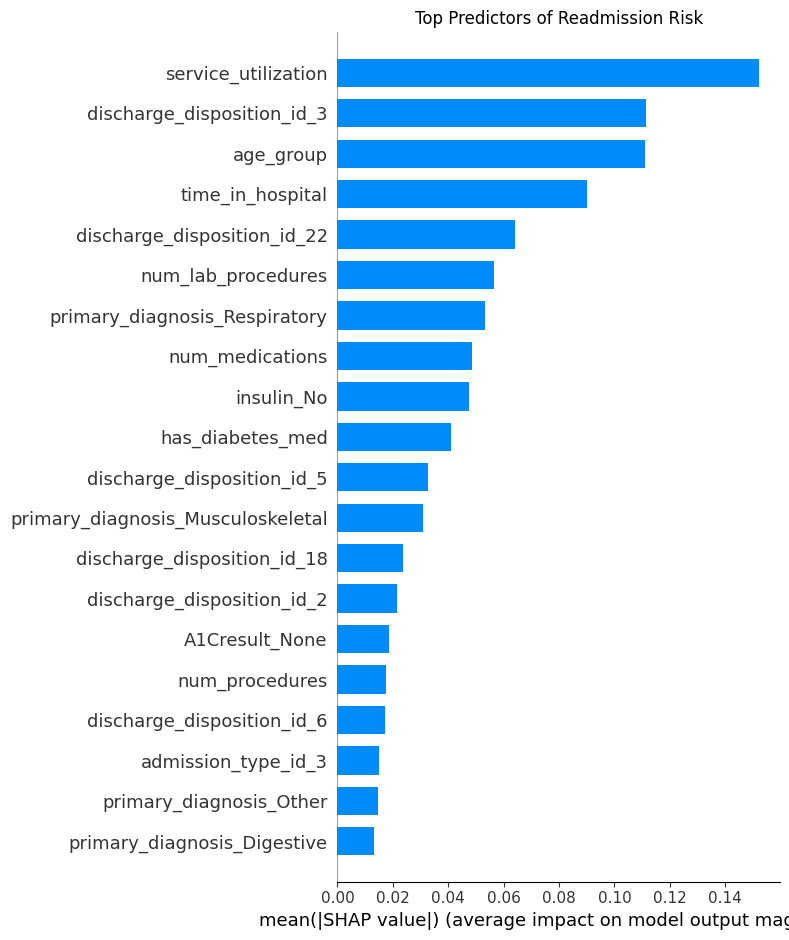

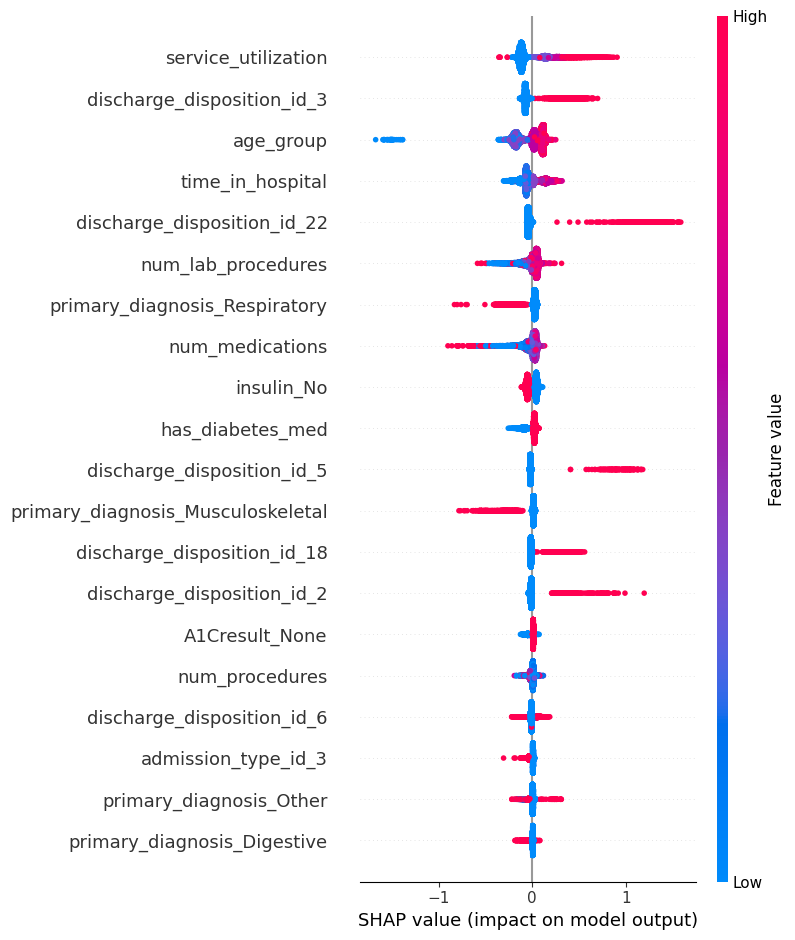

In [9]:
import shap
import matplotlib.pyplot as plt

# 1. Initialize JS for plots
shap.initjs()

# 2. Create the TreeExplainer
# This 'hacks' the XGBoost model to see how it made decisions
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# 3. Summary Plot (The "Bird's Eye View")
# This shows which features are most important globally.
plt.title("Top Predictors of Readmission Risk")
shap.summary_plot(shap_values, X_test, plot_type="bar")

# 4. Detailed Beeswarm Plot
# Shows directionality (e.g., Does high age increase or decrease risk?)
shap.summary_plot(shap_values, X_test)

**STEP 6: QUALITY ASSURANCE (The 'Pytest' Simulation)**

In [11]:
def run_data_quality_checks():
    print("Running Automated Data Quality Tests...")
    tests_passed = 0
    total_tests = 3

    # TEST 1: Check for Data Leakage (FIXED)
    # We use .loc[] because X_train.index has the original Row Labels
    train_ids = df_model.loc[X_train.index].index
    test_ids = df_model.loc[X_test.index].index

    # Check intersection
    overlap = set(train_ids).intersection(set(test_ids))

    try:
        assert len(overlap) == 0
        print("✅ [PASS] Test 1: No Data Leakage detected.")
        tests_passed += 1
    except AssertionError:
        print(f"❌ [FAIL] Test 1: Data Leakage detected! {len(overlap)} overlapping patients.")

    # TEST 2: Prediction Range Sanity Check
    try:
        assert y_prob.min() >= 0 and y_prob.max() <= 1
        print("✅ [PASS] Test 2: Predictions are valid probabilities (0-1).")
        tests_passed += 1
    except AssertionError:
        print("❌ [FAIL] Test 2: Invalid probabilities detected.")

    # TEST 3: Shape Consistency
    try:
        assert X_test.shape[1] == X_train.shape[1]
        print(f"✅ [PASS] Test 3: Feature count matches ({X_train.shape[1]} features).")
        tests_passed += 1
    except AssertionError:
        print("❌ [FAIL] Test 3: Mismatch in feature columns.")

    # Final Report
    if tests_passed == total_tests:
        print("\n🎉 ALL SYSTEM TESTS PASSED. Model is safe to deploy.")
    else:
        print("\n⚠️ WARNING: Some tests failed. Do not deploy.")

# Run the tests
run_data_quality_checks()

Running Automated Data Quality Tests...
✅ [PASS] Test 1: No Data Leakage detected.
✅ [PASS] Test 2: Predictions are valid probabilities (0-1).
✅ [PASS] Test 3: Feature count matches (75 features).

🎉 ALL SYSTEM TESTS PASSED. Model is safe to deploy.


In [12]:
import joblib

# 1. Save the XGBoost Model
model.save_model("xgb_readmission_model.json")

# 2. Save the Feature Names (Critical for One-Hot Encoding consistency)
# We need to ensure the app creates the exact same 75 columns.
feature_names = X_train.columns.tolist()
joblib.dump(feature_names, "feature_names.pkl")

print("✅ Model and Features saved successfully!")

✅ Model and Features saved successfully!


In [13]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib

# --- 1. LOAD ASSETS ---
@st.cache_resource
def load_assets():
    model = xgb.XGBClassifier()
    model.load_model("xgb_readmission_model.json")
    feature_names = joblib.load("feature_names.pkl")
    return model, feature_names

model, feature_names = load_assets()

# --- 2. UI HEADER ---
st.title("🏥 30-Day Readmission Shield")
st.markdown("""
This tool predicts the risk of a diabetic patient being readmitted within 30 days.
*Built with XGBoost & SHAP*
""")

# --- 3. SIDEBAR INPUTS ---
st.sidebar.header("Patient Profile")

# Demographics
gender = st.sidebar.selectbox("Gender", ["Female", "Male"])
race = st.sidebar.selectbox("Race", ["Caucasian", "AfricanAmerican", "Hispanic", "Other", "Asian"])
age_group = st.sidebar.slider("Age Group (0=0-10, 9=90-100)", 0, 9, 7)

# Medical History
time_in_hospital = st.sidebar.number_input("Days in Hospital", 1, 14, 3)
num_lab_procedures = st.sidebar.number_input("Num Lab Procedures", 0, 150, 40)
num_medications = st.sidebar.number_input("Num Medications", 0, 100, 15)
service_utilization = st.sidebar.number_input("Prior Visits (Emergency/Inpatient)", 0, 20, 1)

# Diagnoses
primary_diagnosis = st.sidebar.selectbox("Primary Diagnosis Group",
    ['Circulatory', 'Respiratory', 'Digestive', 'Diabetes', 'Injury',
     'Musculoskeletal', 'Genitourinary', 'Neoplasms', 'Other'])

# Lab Results
a1c_result = st.sidebar.selectbox("A1C Result", ["None", "Norm", ">7", ">8"])
max_glu_serum = st.sidebar.selectbox("Max Glu Serum", ["None", "Norm", ">200", ">300"])

# --- 4. PREDICTION LOGIC ---
if st.sidebar.button("Predict Risk"):

    # A. Create a Dictionary of Inputs
    # Note: We only map the inputs we use.
    # Categoricals must match the strings in your training data EXACTLY.
    input_data = {
        'gender': gender,
        'race': race,
        'age_group': age_group,
        'time_in_hospital': time_in_hospital,
        'num_lab_procedures': num_lab_procedures,
        'num_medications': num_medications,
        'service_utilization': service_utilization,
        'primary_diagnosis': primary_diagnosis,
        'A1Cresult': a1c_result,
        'max_glu_serum': max_glu_serum,
        # Default values for fields we didn't ask for (simplification for UI)
        'admission_type_id': '1',
        'discharge_disposition_id': '1',
        'admission_source_id': '7',
        'insulin': 'No',
        'med_change': 0,
        'has_diabetes_med': 1
    }

    # B. Convert to DataFrame
    df_input = pd.DataFrame([input_data])

    # C. One-Hot Encoding (The Tricky Part)
    # We apply get_dummies to the user input
    df_input_encoded = pd.get_dummies(df_input)

    # D. Align with Training Features
    # The user input might be missing columns (e.g., if they selected "Male", "gender_Female" won't exist).
    # We reindex to match the saved 'feature_names', filling missing cols with 0.
    df_final = df_input_encoded.reindex(columns=feature_names, fill_value=0)

    # E. Predict
    prediction = model.predict(df_final)[0]
    probability = model.predict_proba(df_final)[0][1]

    # --- 5. DISPLAY RESULTS ---
    st.divider()

    col1, col2 = st.columns(2)

    with col1:
        if prediction == 1:
            st.error(f"⚠️ High Risk of Readmission")
            st.metric("Risk Probability", f"{probability:.1%}")
        else:
            st.success(f"✅ Low Risk")
            st.metric("Risk Probability", f"{probability:.1%}")

    with col2:
        st.info("Key Risk Factors Detected:")
        # Simple rule-based explanation for the demo
        if service_utilization > 1: st.write("- High History of Hospital Use")
        if num_medications > 20: st.write("- Polypharmacy (High Meds)")
        if age_group > 7: st.write("- Advanced Age")
        if primary_diagnosis == 'Circulatory': st.write("- Circulatory Diagnosis")

Writing app.py
